In [1]:

import concurrent.futures

import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap as colorMap
from matplotlib.ticker import PercentFormatter

import ansys.additive as pyadditive


In [2]:
additive = pyadditive.Additive()
material = additive.get_material('17-4PH') 

INFO:ansys.additive.additive:Connected to 127.0.0.1:50052


user data path: C:\Users\pkrull\AppData\Local\Ansys Inc.\ansys-pyadditive


In [3]:
# Single bead evaluation
# power range: 50 - 700 (w)
# scan speed range: .350 - 2.500 (m/s)
initial_powers = [50, 170, 340, 510, 700]
initial_scan_speeds = [.35, 0.75, 1.25, 1.75, 2.25, 2.5]
bead_length = 0.001
bead_type = pyadditive.BeadType.BEAD_ON_POWDER
# Use a comprehension to create a list of 9 machines
machines = [
    pyadditive.AdditiveMachine(laser_power=p, scan_speed=s) 
    for p in initial_powers 
    for s in initial_scan_speeds
]
inputs = []
for count, machine in enumerate(machines):
    inputs.append(
        pyadditive.SingleBeadInput(
            id=f"single-bead-opt-{count}",
            material=material,
            machine=machine,
            bead_length=bead_length,
            bead_type=bead_type,
        )
    )
    
###############################################################################
# Run Simulations
# ---------------
# We run the simulations in parallel and store the summaries as each simulation
# completes.
# *NOTE: At present it is not recommended to run more than 10 concurrent simulations.*
sb_summaries = []
completed = 0
total_simulations = len(inputs)
print(f"Running {total_simulations} simulations")
with concurrent.futures.ThreadPoolExecutor(10) as executor:
    futures = []
    for input in inputs:
        futures.append(executor.submit(additive.simulate, input=input, log_progress=False))
    for future in concurrent.futures.as_completed(futures):
        sb_summaries.append(future.result())
        completed += 1
        print(f"Completed {completed} of {total_simulations} simulations")




Running 30 simulations
Completed 1 of 30 simulations
Completed 2 of 30 simulations
Completed 3 of 30 simulations
Completed 4 of 30 simulations
Completed 5 of 30 simulations
Completed 6 of 30 simulations
Completed 7 of 30 simulations
Completed 8 of 30 simulations
Completed 9 of 30 simulations
Completed 10 of 30 simulations
Completed 11 of 30 simulations
Completed 12 of 30 simulations
Completed 13 of 30 simulations
Completed 14 of 30 simulations
Completed 15 of 30 simulations
Completed 16 of 30 simulations
Completed 17 of 30 simulations
Completed 18 of 30 simulations
Completed 19 of 30 simulations
Completed 20 of 30 simulations
Completed 21 of 30 simulations
Completed 22 of 30 simulations
Completed 23 of 30 simulations
Completed 24 of 30 simulations
Completed 25 of 30 simulations
Completed 26 of 30 simulations
Completed 27 of 30 simulations
Completed 28 of 30 simulations
Completed 29 of 30 simulations
Completed 30 of 30 simulations


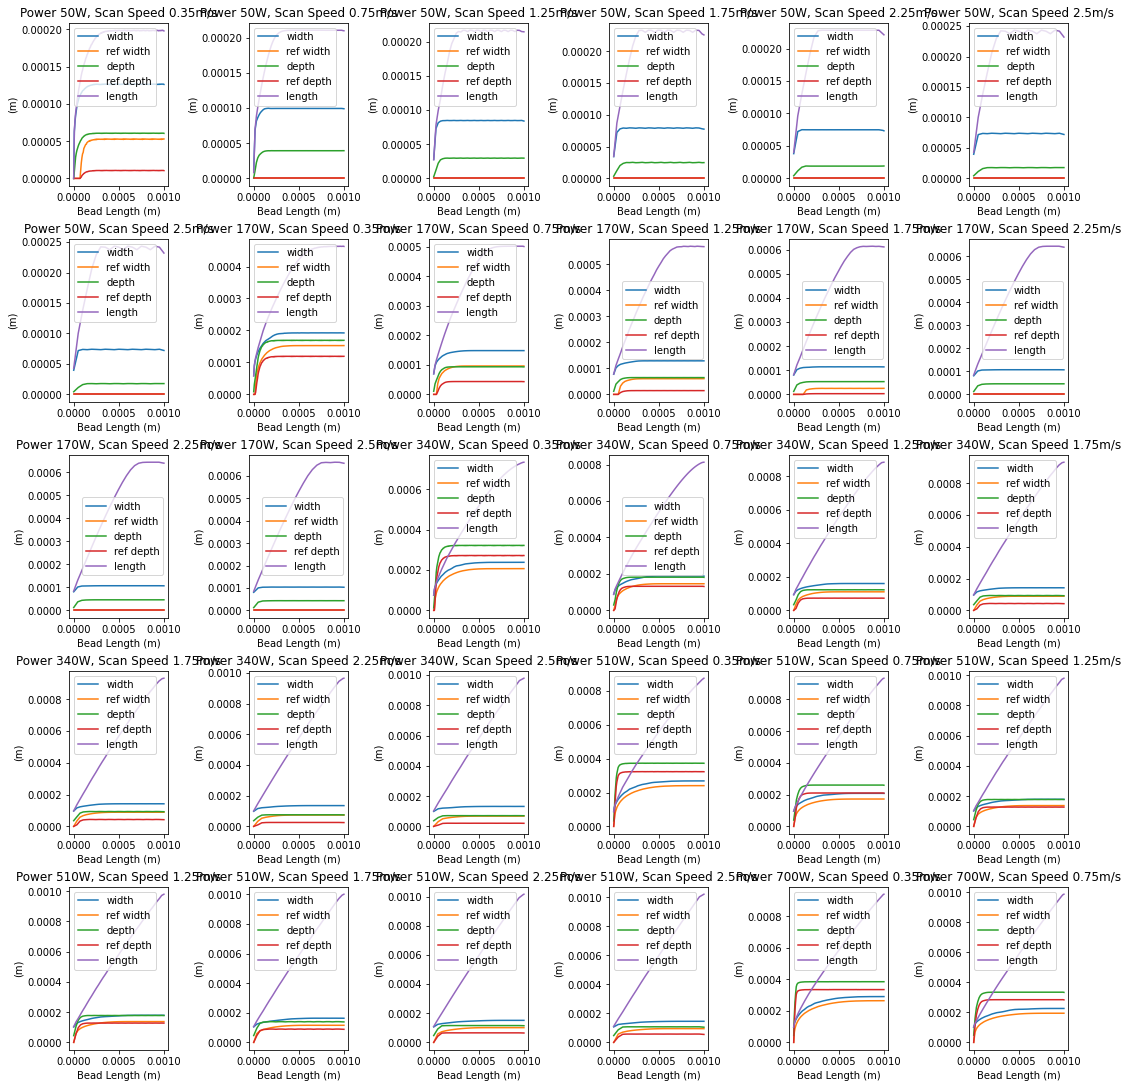

In [4]:
###############################################################################
# Plot Individual Meltpool Statistics
# -----------------------------------
sb_summaries.sort(key=lambda s: (s.input.machine.laser_power, s.input.machine.scan_speed))
nrows = len(initial_powers)
ncols = len(initial_scan_speeds)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15), layout="constrained")
for r in range(nrows):
    for c in range(ncols):
        i = r * nrows + c
        mp = sb_summaries[i].melt_pool
        axs[r][c].plot(mp.laser_x, mp.width, label="width")
        axs[r][c].plot(mp.laser_x, mp.reference_width, label="ref width")
        axs[r][c].plot(mp.laser_x, mp.depth, label="depth")
        axs[r][c].plot(mp.laser_x, mp.reference_depth, label="ref depth")
        axs[r][c].plot(mp.laser_x, mp.length, label="length")
        axs[r][c].legend()
        axs[r][c].set_xlabel(f"Bead Length (m)")  # Add an x-label to the axes.
        axs[r][c].set_ylabel(f"(m)")  # Add a y-label to the axes.
        title = (
            "Power "
            + str(sb_summaries[i].input.machine.laser_power)
            + "W, Scan Speed "
            + str(sb_summaries[i].input.machine.scan_speed)
            + "m/s"
        )
        axs[r][c].set_title(title)  # Add a title to the axes.


Text(0, 0.5, 'Laser Power (W)')

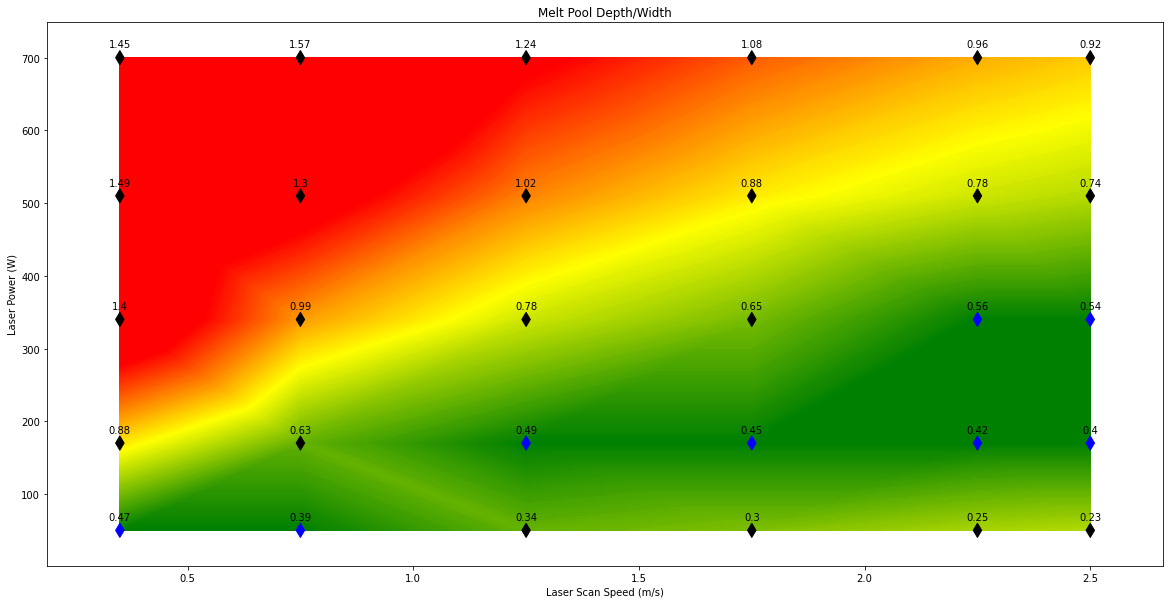

In [5]:
###############################################################################
# Plot Meltpool Average Depth Over Width Verses Laser Power And Scan Speed
# ------------------------------------------------------------------------
# Here we create a "watermelon" plot to visualize the optimal laser power
# and scan speed combinations.

# Gather plot values
powers = []
scan_speeds = []
depth_over_width = []

for s in sb_summaries:
    mp = s.melt_pool
    ave_width = np.average(mp.width)
    ave_depth = np.average(mp.depth)
    powers.append(s.input.machine.laser_power)
    scan_speeds.append(s.input.machine.scan_speed)
    depth_over_width.append(ave_depth / ave_width if ave_width else 0)

# Create plot, adjust dwMin and dwMax for desired acceptable range.
dwMin = 0.37
dwMax = 0.6
contour_gradient = []
marker_colors = []
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(depth_over_width)):
    if dwMin < depth_over_width[i] < dwMax:
        contour_gradient.append(0)
        marker_colors.append("blue")
    else:
        contour_gradient.append(abs(((dwMax + dwMin) / 2) - depth_over_width[i]))
        marker_colors.append("black")
    txt = "{}".format(round(depth_over_width[i], 2))
    ax.annotate(
        str(txt),
        (scan_speeds[i], powers[i] + 25),
        verticalalignment="top",
        horizontalalignment="center",
    )

colMap = colorMap.from_list("", ["green", "yellow", "red", "red"])
ax.tricontourf(scan_speeds, powers, contour_gradient, cmap=colMap, levels=255)
ax.scatter(scan_speeds, powers, c=marker_colors, marker="d", s=100, facecolor="none")
ax.use_sticky_edges = False
ax.margins(0.075)
ax.set_title("Melt Pool Depth/Width")
ax.set_xlabel(f"Laser Scan Speed (m/s)")
ax.set_ylabel(f"Laser Power (W)")

In [18]:
# Perform porosity evaluation
# Determine laser power and scan speed combinations of interest
dwMin = 0.45
dwMax = 0.55
ps_of_interest = []
for i, dw in enumerate(depth_over_width):
    if dwMin < dw < dwMax:
        ps_of_interest.append((powers[i], scan_speeds[i]))

# Vary hatch spacing, valid hatch spacing: 6e-5 to 2e-4
hatch_spacings = [6e-5, 1e-4, 2e-4]

machines = [
    pyadditive.AdditiveMachine(laser_power=ps[0], scan_speed=ps[1], hatch_spacing=h)
    for ps in ps_of_interest
    for h in hatch_spacings
]
inputs = []
for count, machine in enumerate(machines):
    inputs.append(
        pyadditive.PorosityInput(
            id=f"porosity-opt-{count}",
            material=material,
            machine=machine,
            size_x = 0.001,
            size_y = 0.001,
            size_z = 0.001,
        )
    )
total_simulations = len(inputs)
print(f'Starting {total_simulations} porosity simulations')
porosity_summaries = []
with concurrent.futures.ThreadPoolExecutor(8) as executor:
    futures = []
    completed = 0
    for input in inputs:
        futures.append(executor.submit(additive.simulate, input=input, log_progress=False))
    for future in concurrent.futures.as_completed(futures):
        porosity_summaries.append(future.result())
        completed += 1
        print(f"Completed {completed} of {total_simulations} simulations")



Starting 12 porosity simulations
Completed 1 of 12 simulations
Completed 2 of 12 simulations
Completed 3 of 12 simulations
Completed 4 of 12 simulations
Completed 5 of 12 simulations
Completed 6 of 12 simulations
Completed 7 of 12 simulations
Completed 8 of 12 simulations
Completed 9 of 12 simulations
Completed 10 of 12 simulations
Completed 11 of 12 simulations
Completed 12 of 12 simulations


In [7]:
# Function for calculating build rate per cubic centimeter
def build_rate_cm_per_sec(scan_speed: float, hatch_spacing: float, layer_thickness: float) -> float:
    # convert all values to cm
    ss = scan_speed * 100
    hs = hatch_spacing * 100
    lt = layer_thickness * 100
    
    # calculate the time to scan a cubic centimeter
    n_layers = 1 / lt 
    lines_per_layer = 1 / hs
    return ss / (n_layers * lines_per_layer) # cc / sec

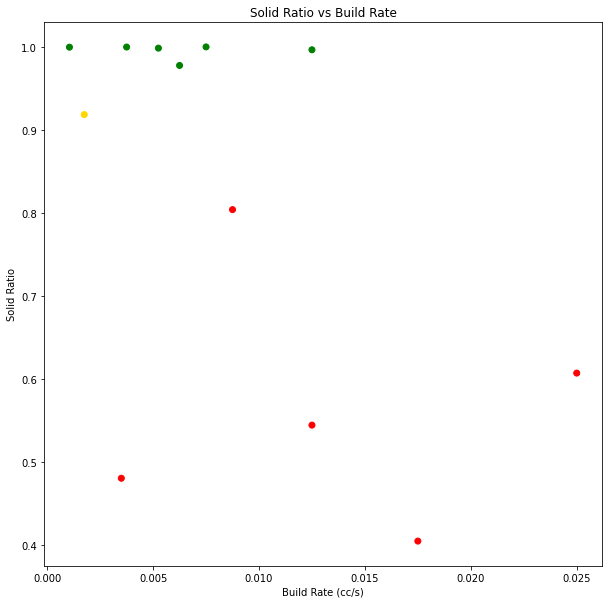

In [19]:
# Plot solid ratio versus build rate
# Gather values
solid_ratios = [x.solid_ratio for x in porosity_summaries]
build_rates = [
    build_rate_cm_per_sec(
        x.input.machine.scan_speed, 
        x.input.machine.hatch_spacing, 
        x.input.machine.layer_thickness) 
    for x in porosity_summaries]
marker_colors = []
marker_green = 0.95
marker_yellow = 0.85
fig, ax = plt.subplots(figsize=(10,10))

ax.set(xlabel=f'Build Rate (cc/s)', ylabel=f'Solid Ratio', title='Solid Ratio vs Build Rate')
for i in range(len(solid_ratios)):
    if solid_ratios[i] > marker_green:
        marker_colors.append('green')
    elif solid_ratios[i] > marker_yellow:
        marker_colors.append('gold')
    else:
        marker_colors.append('red')
    txt = "{}".format(round(solid_ratios[i], 2))
    ax.annotate(str(txt), (build_rates[i], solid_ratios[i] + 25), xycoords='data', color='black', verticalalignment='top', horizontalalignment='center')
ax.scatter(build_rates, solid_ratios, c=marker_colors, facecolor='none')

plt.show()

In [20]:
# Filter porosity results for microstructure analysis
min_solid_ratio = 0.99
machines = [
    pyadditive.AdditiveMachine(
        beam_diameter=p.input.machine.beam_diameter,
        hatch_spacing=p.input.machine.hatch_spacing,
        heater_temperature=p.input.machine.heater_temperature,
        laser_power=p.input.machine.laser_power,
        layer_rotation_angle=p.input.machine.layer_rotation_angle,
        layer_thickness=p.input.machine.layer_thickness,
        scan_speed=p.input.machine.scan_speed,
        slicing_stripe_width=p.input.machine.slicing_stripe_width,
        starting_layer_angle=p.input.machine.starting_layer_angle
    )
    for p in porosity_summaries if p.solid_ratio >= min_solid_ratio
]

inputs = []
for count, machine in enumerate(machines):
    inputs.append(
        pyadditive.MicrostructureInput(
            id=f"micro-opt-{count}",
            material=material,
            machine=machine
        )
    )

print(len(inputs))

5


In [15]:

###############################################################################
# Run Simulations
# ---------------
# We run the simulations in parallel and store the summaries as each simulation
# completes.
# *NOTE: At present it is not recommended to run more than 10 concurrent simulations.*
micro_summaries = []
completed = 0
total_simulations = len(inputs)
print(f"Running {total_simulations} simulations")
with concurrent.futures.ThreadPoolExecutor(10) as executor:
    futures = []
    for input in inputs:
        futures.append(executor.submit(additive.simulate, input=input, log_progress=False))
    for future in concurrent.futures.as_completed(futures):
        micro_summaries.append(future.result())
        completed += 1
        print(f"Completed {completed} of {total_simulations} simulations")



Running 7 simulations
Completed 1 of 7 simulations
Completed 2 of 7 simulations
Completed 3 of 7 simulations
Completed 4 of 7 simulations
Completed 5 of 7 simulations
Completed 6 of 7 simulations
Completed 7 of 7 simulations


In [16]:
import pyvista as pv
###############################################################################
# Plot Grain 2D Visualtions
# ^^^^^^^^^^^^^^^^^^^^^^^^^

# Function to plot the planar data
def plot_microstructure(
    xy_data: any, xz_data: any, yz_data: any, scalars: str, cmap: colors.LinearSegmentedColormap
):
    """Convenience function to plot microstructure VTK data."""
    font_size = 8
    plotter = pv.Plotter(shape=(2, 2), lighting="three lights")
    plotter.show_axes_all()
    plotter.add_mesh(xy_data, cmap=cmap, scalars=scalars)
    plotter.add_title("XY Plane", font_size=font_size)

    plotter.subplot(0, 1)
    plotter.add_mesh(xz_data, cmap=cmap, scalars=scalars)
    plotter.add_title("XZ Plane", font_size=font_size)

    plotter.subplot(1, 0)
    plotter.add_mesh(yz_data, cmap=cmap, scalars=scalars)
    plotter.add_title("YZ Plane", font_size=font_size)

    plotter.subplot(1, 1)
    plotter.add_mesh(xy_data, cmap=cmap, scalars=scalars)
    plotter.add_mesh(xz_data, cmap=cmap, scalars=scalars)
    plotter.add_mesh(yz_data, cmap=cmap, scalars=scalars)
    plotter.add_title("Combined", font_size=font_size)

    return plotter


# Read VTK data into pyvista.DataSet objects
# Plot first summary
summary = micro_summaries[0]
xy = pv.read(summary.xy_vtk)
xz = pv.read(summary.xz_vtk)
yz = pv.read(summary.yz_vtk)

# Create colormap to use with boundary plot
white_black_cmap = colorMap.from_list("whiteblack", ["white", "black"])

plot_microstructure(xy, xz, yz, "GrainBoundaries", white_black_cmap).show(title="Grain Boundaries")
plot_microstructure(xy, xz, yz, "Orientation_(deg)", "spectral").show(title="Orientation °")
plot_microstructure(xy, xz, yz, "GrainNumber", None).show(title="Grain Number")


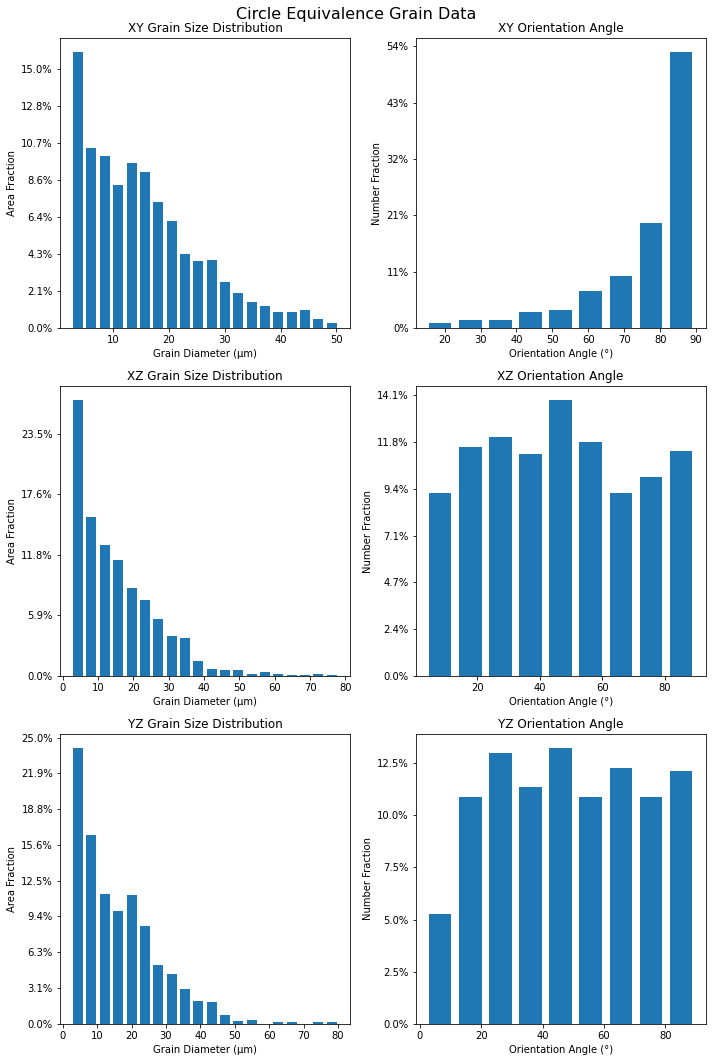

In [17]:
###############################################################################
# Plot Grain Statistics
# ^^^^^^^^^^^^^^^^^^^^^

# Function to simplify plotting grain statistics
def add_grain_statistics_to_figure(
    plane_data: dict, plane_str: str, diameter_axes: plt.Axes, orientation_axes: plt.Axes
):
    """Convenience function to add grain statistic plots to a figure."""
    xmax = len(plane_data["diameter_um"])
    diameter_axes.hist(plane_data["diameter_um"], bins=20, rwidth=0.75)
    diameter_axes.set_xlabel(f"Grain Diameter (µm)")
    diameter_axes.set_ylabel("Area Fraction")
    diameter_axes.set_title(plane_str.upper() + " Grain Size Distribution")
    diameter_axes.yaxis.set_major_formatter(PercentFormatter(xmax=xmax))
    orientation_axes.hist(plane_data["orientation_angle"], bins=9, rwidth=0.75)
    orientation_axes.yaxis.set_major_formatter(PercentFormatter(xmax=xmax))
    orientation_axes.set_xlabel(f"Orientation Angle (°)")
    orientation_axes.set_ylabel("Number Fraction")
    orientation_axes.set_title(plane_str.upper() + " Orientation Angle")


# Create figure for grain statistics
fig, axs = plt.subplots(3, 2, figsize=(10, 15), tight_layout=True)
fig.suptitle("Circle Equivalence Grain Data", fontsize=16)
add_grain_statistics_to_figure(summary.xy_circle_equivalence, "xy", axs[0][0], axs[0][1])
add_grain_statistics_to_figure(summary.xz_circle_equivalence, "xz", axs[1][0], axs[1][1])
add_grain_statistics_to_figure(summary.yz_circle_equivalence, "yz", axs[2][0], axs[2][1])
plt.show()